# From tokens to numbers: the document-term matrix

The bag of words model represents a document based on the frequency of the terms or tokens it contains. Each document becomes a vector with one entry for each token in the vocabulary that reflects the token’s relevance to the document.

The document-term matrix is straightforward to compute given the vocabulary. However, it is also a crude simplification because it abstracts from word order and grammatical relationships. Nonetheless, it often achieves good results in text classification quickly and, thus, a very useful starting point.

There are several ways to weigh a token’s vector entry to capture its relevance to the document. We will illustrate below how to use sklearn to use binary flags that indicate presence or absence, counts, and weighted counts that account for differences in term frequencies across all documents, i.e., in the corpus. 

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from scipy.spatial.distance import pdist

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from ipywidgets import interact, FloatRangeSlider

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

In [3]:
sns.set_style('white')

## Load BBC data

In [4]:
path = Path('..', 'data', 'bbc')
files = sorted(list(path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    topic = file.parts[-2]
    article = file.read_text(encoding='latin1').split('\n')
    heading = article[0].strip()
    body = ' '.join([l.strip() for l in article[1:]]).strip()
    doc_list.append([topic, heading, body])

### Convert to DataFrame

In [5]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'body'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   body     2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


### Inspect results

In [6]:
docs.sample(10)

,topic,heading,body
1744,sport,Davenport hits out at Wimbledon,World number one Lindsay Davenport has critici...
1919,tech,California sets fines for spyware,The makers of computer programs that secretly ...
1937,tech,Games maker fights for survival,One of Britain's largest independent game make...
965,politics,Opposition grows to house arrests,"The Conservatives have expressed ""serious misg..."
1799,sport,Officials respond in court row,Australian tennis' top official has defended t...
998,politics,Minimum rate for foster parents,Foster carers are to be guaranteed a minimum a...
2038,tech,Europe backs digital TV lifestyle,How people receive their digital entertainment...
1823,sport,Roddick to face Saulnier in final,Andy Roddick will play Cyril Saulnier in the f...
57,business,Electrolux to export Europe jobs,Electrolux saw its shares rise 14% on Tuesday ...
345,business,Disaster claims 'less than $10bn',Insurers have sought to calm fears that they f...


### Data drawn from 5 different categories

In [7]:
docs.topic.value_counts(normalize=True).to_frame('count').style.format({'count': '{:,.2%}'.format})

,count
sport,22.97%
business,22.92%
politics,18.74%
tech,18.02%
entertainment,17.35%


## Explore Corpus

### Token Count via Counter()

In [8]:
# word count
word_count = docs.body.str.split().str.len().sum()
print(f'Total word count: {word_count:,d} | per article: {word_count/len(docs):,.0f}')

Total word count: 842,910 | per article: 379


In [9]:
token_count = Counter()
for i, doc in enumerate(docs.body.tolist(), 1):
    if i % 500 == 0:
        print(i, end=' ', flush=True)
    token_count.update([t.strip() for t in doc.split()])

500 1000 1500 2000 

In [10]:
tokens = (pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
          .set_index('token')
          .squeeze())

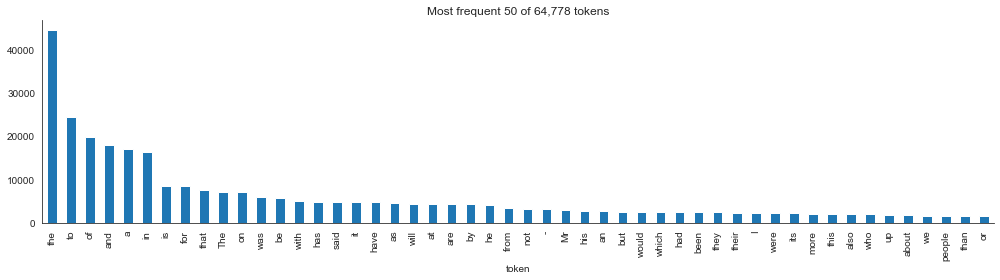

In [11]:
n = 50
(tokens
 .iloc[:50]
 .plot
 .bar(figsize=(14, 4), title=f'Most frequent {n} of {len(tokens):,d} tokens'))
sns.despine()
plt.tight_layout();

## Document-Term Matrix with `CountVectorizer`

The scikit-learn preprocessing module offers two tools to create a document-term matrix. The [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) uses binary or absolute counts to measure the term frequency tf(d, t) for each document d and token t.

The [TfIDFVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), in contrast, weighs the (absolute) term frequency by the inverse document frequency (idf). As a result, a term that appears in more documents will receive a lower weight than a token with the same frequency for a given document but lower frequency across all documents. 

The resulting tf-idf vectors for each document are normalized with respect to their absolute or squared totals (see the sklearn documentation for details). The tf-idf measure was originally used in information retrieval to rank search engine results and has subsequently proven useful for text classification or clustering.

Both tools use the same interface and perform tokenization and further optional preprocessing of a list of documents before vectorizing the text by generating token counts to populate the document-term matrix.

Key parameters that affect the size of the vocabulary include:

- `stop_words`: use a built-in or provide a list of (frequent) words to exclude
- `ngram_range`: include n-grams in a range for n defined by a tuple of (nmin, nmax)
- `lowercase`: convert characters accordingly (default is True)
- `min_df `/ max_df: ignore words that appear in less / more (int) or a smaller / larger share of documents (if float [0.0,1.0])
- `max_features`: limit number of tokens in vocabulary accordingly
- `binary`: set non-zero counts to 1 True

### Key parameters

In [12]:
print(CountVectorizer().__doc__)

Convert a collection of text documents to a matrix of token counts

    This implementation produces a sparse representation of the counts using
    scipy.sparse.csr_matrix.

    If you do not provide an a-priori dictionary and you do not use an analyzer
    that does some kind of feature selection then the number of features will
    be equal to the vocabulary size found by analyzing the data.

    Read more in the :ref:`User Guide <text_feature_extraction>`.

    Parameters
    ----------
    input : string {'filename', 'file', 'content'}, default='content'
        If 'filename', the sequence passed as an argument to fit is
        expected to be a list of filenames that need reading to fetch
        the raw content to analyze.

        If 'file', the sequence items must have a 'read' method (file-like
        object) that is called to fetch the bytes in memory.

        Otherwise the input is expected to be a sequence of items that
        can be of type string or byte.

    encodin

### Document Frequency Distribution

In [13]:
binary_vectorizer = CountVectorizer(max_df=1.0,
                                    min_df=1,
                                    binary=True)

binary_dtm = binary_vectorizer.fit_transform(docs.body)

In [14]:
binary_dtm

<2225x29275 sparse matrix of type '<class 'numpy.int64'>'
	with 445870 stored elements in Compressed Sparse Row format>

In [15]:
n_docs, n_tokens = binary_dtm.shape

In [16]:
tokens_dtm = binary_vectorizer.get_feature_names()

#### CountVectorizer skips certain tokens by default

In [17]:
tokens.index.difference(pd.Index(tokens_dtm))

Index(['!', '"', '""unconscionable,', '"'I', '"'Oh', '"'We', '"'You', '"(When',
       '"...it', '"100%',
       ...
       'Â£900m', 'Â£910m).', 'Â£93.6bn)', 'Â£933m', 'Â£947m', 'Â£960m',
       'Â£98)', 'Â£99', 'Â£9m', 'Â£9m,'],
      dtype='object', length=47927)

#### Persist Result

In [ ]:
results_path = Path('results', 'bbc')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [18]:
dtm_path = results_path / 'binary_dtm.npz'
if not dtm_path.exists():
    sparse.save_npz(dtm_path, binary_dtm)

In [19]:
token_path = results_path / 'tokens.csv'
if not token_path.exists():
    pd.Series(tokens_dtm).to_csv(token_path, index=False)
else:
    tokens = pd.read_csv(token_path, header=None, squeeze=True)

In [20]:
doc_freq = pd.Series(np.array(binary_dtm.sum(axis=0)).squeeze()).div(n_docs)
max_unique_tokens = np.array(binary_dtm.sum(axis=1)).squeeze().max()

### `min_df` vs `max_df`: Interactive Visualization

The notebook contains an interactive visualization that explores the impact of the min_df and max_df settings on the size of the vocabulary. We read the articles into a DataFrame, set the CountVectorizer to produce binary flags and use all tokens, and call its .fit_transform() method to produce a document-term matrix:

The visualization shows that requiring tokens to appear in at least 1%  and less than 50% of documents restricts the vocabulary to around 10% of the almost 30K tokens. 
This leaves a mode of slightly over 100 unique tokens per document (left panel), and the right panel shows the document frequency histogram for the remaining tokens.

In [21]:
df_range = FloatRangeSlider(value=[0.0, 1.0],
                            min=0,
                            max=1,
                            step=0.0001,
                            description='Doc. Freq.',
                            disabled=False,
                            continuous_update=True,
                            orientation='horizontal',
                            readout=True,
                            readout_format='.1%',
                            layout={'width': '800px'})

@interact(df_range=df_range)
def document_frequency_simulator(df_range):
    min_df, max_df = df_range
    keep = doc_freq.between(left=min_df, right=max_df)
    left = keep.sum()

    fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

    updated_dtm = binary_dtm.tocsc()[:, np.flatnonzero(keep)]
    unique_tokens_per_doc = np.array(updated_dtm.sum(axis=1)).squeeze()
    sns.distplot(unique_tokens_per_doc, ax=axes[0], kde=False, norm_hist=False)
    axes[0].set_title('Unique Tokens per Doc')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('# Unique Tokens')
    axes[0].set_ylabel('# Documents (log scale)')
    axes[0].set_xlim(0, max_unique_tokens)    
    axes[0].yaxis.set_major_formatter(ScalarFormatter())

    term_freq = pd.Series(np.array(updated_dtm.sum(axis=0)).squeeze())
    sns.distplot(term_freq, ax=axes[1], kde=False, norm_hist=False)
    axes[1].set_title('Document Frequency')
    axes[1].set_ylabel('# Tokens')
    axes[1].set_xlabel('# Documents')
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, n_docs)
    axes[1].yaxis.set_major_formatter(ScalarFormatter())

    title = f'Document/Term Frequency Distribution | # Tokens: {left:,d} ({left/n_tokens:.2%})'
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='Doc. Freq.', layout=Layout(width='800px'…

### Most similar documents

The CountVectorizer result lets us find the most similar documents using the `pdist()` function for pairwise distances provided by the `scipy.spatial.distance` module. 

It returns a  condensed distance matrix with entries corresponding to the upper triangle of a square matrix. 

We use `np.triu_indices()` to translate the index that minimizes the distance to the row and column indices that in turn correspond to the closest token vectors. 

In [22]:
m = binary_dtm.todense()
pairwise_distances = pdist(m, metric='cosine')

In [23]:
closest = np.argmin(pairwise_distances)

In [24]:
rows, cols = np.triu_indices(n_docs)
rows[closest], cols[closest]

(6, 245)

In [25]:
docs.iloc[6].to_frame(6).join(docs.iloc[245].to_frame(245)).to_csv(results_path / 'most_similar.csv')

In [26]:
docs.iloc[6]

topic                                               business
heading                     Jobs growth still slow in the US
body       The US created fewer jobs than expected in Jan...
Name: 6, dtype: object

In [27]:
pd.DataFrame(binary_dtm[[6, 245], :].todense()).sum(0).value_counts()

0    28972
1      265
2       38
dtype: int64

### Baseline document-term matrix

In [28]:
# Baseline: number of unique tokens
vectorizer = CountVectorizer() # default: binary=False
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix

<2225x29275 sparse matrix of type '<class 'numpy.int64'>'
	with 445870 stored elements in Compressed Sparse Row format>

In [29]:
doc_term_matrix.shape

(2225, 29275)

### Inspect tokens

In [30]:
# vectorizer keeps words
words = vectorizer.get_feature_names()
words[:10]

['00',
 '000',
 '0001',
 '000bn',
 '000m',
 '000s',
 '000th',
 '001',
 '001and',
 '001st']

### Inspect doc-term matrix

In [31]:
# from scipy compressed sparse row matrix to sparse DataFrame
doc_term_matrix_df = pd.DataFrame.sparse.from_spmatrix(doc_term_matrix, columns=words)
doc_term_matrix_df.head()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,zooms,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Most frequent terms

In [32]:
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head() 

the    52574
to     24767
of     19930
and    18574
in     17553
dtype: int64

### Compute relative term frequency

In [33]:
vectorizer = CountVectorizer(binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 29275)

In [34]:
words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)

# reduce to 1D array
word_freq_1d = np.squeeze(np.asarray(word_freq))

pd.Series(word_freq_1d, index=words).div(
    docs.shape[0]).sort_values(ascending=False).head(10)

the     1.000000
to      0.995056
of      0.991461
and     0.991011
in      0.990562
for     0.930337
on      0.906517
is      0.862472
it      0.858427
said    0.848539
dtype: float64

### Visualize Doc-Term Matrix

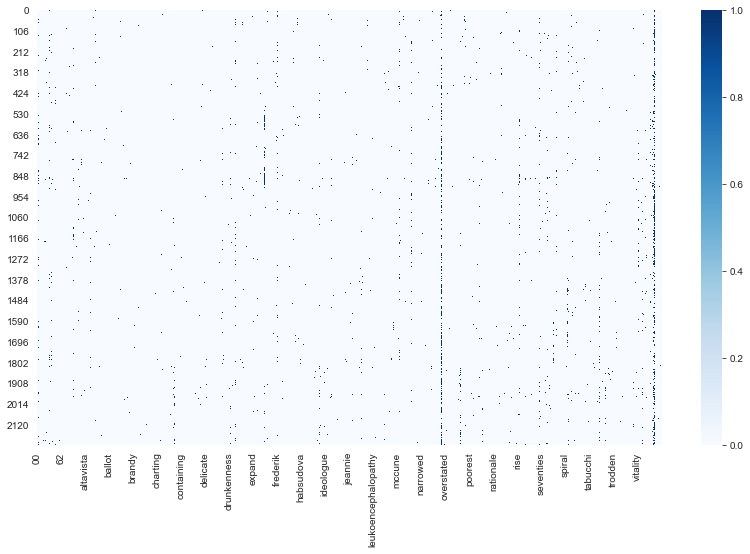

In [35]:
sns.heatmap(pd.DataFrame(doc_term_matrix.todense(), columns=words), cmap='Blues')
plt.gcf().set_size_inches(14, 8);

### Using thresholds to reduce the number of tokens 

In [36]:
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 12789)

### Use CountVectorizer with Lemmatization

#### Building a custom `tokenizer` for Lemmatization with `spacy`

In [37]:
nlp = spacy.load('en')
def tokenizer(doc):
    return [w.lemma_ for w in nlp(doc) 
                if not w.is_punct | w.is_space]

In [38]:
vectorizer = CountVectorizer(tokenizer=tokenizer, binary=True)
doc_term_matrix = vectorizer.fit_transform(docs.body)
doc_term_matrix.shape

(2225, 25665)

In [39]:
lemmatized_words = vectorizer.get_feature_names()
word_freq = doc_term_matrix.sum(axis=0)
word_freq_1d = np.squeeze(np.asarray(word_freq))
word_freq_1d = pd.Series(word_freq_1d, index=lemmatized_words).div(docs.shape[0])
word_freq_1d.sort_values().tail(20)

from      0.702022
but       0.732135
as        0.742022
by        0.765843
at        0.792809
with      0.824719
that      0.830562
say       0.881798
's        0.896629
on        0.906517
for       0.930337
have      0.972584
in        0.990562
and       0.991011
of        0.991461
a         0.992809
-PRON-    0.993708
to        0.995056
be        0.998202
the       1.000000
dtype: float64

Unlike verbs and common nouns, there's no clear base form of a personal pronoun. Should the lemma of "me" be "I", or should we normalize person as well, giving "it" — or maybe "he"? spaCy's solution is to introduce a novel symbol, -PRON-, which is used as the lemma for all personal pronouns.

## Document-Term Matrix with `TfIDFVectorizer`

The TfIDFTransfomer computes the tf-idf weights from a document-term matrix of token counts like the one produced by the CountVectorizer. 

The TfIDFVectorizer performs both computations in a single step. It adds a few parameters to the CountVectorizer API that controls the smoothing behavior.

### Key Parameters

The `TfIDFTransformer` builds on the `CountVectorizer` output; the `TfIDFVectorizer` integrates both

In [40]:
print(TfidfTransformer().__doc__)

Transform a count matrix to a normalized tf or tf-idf representation

    Tf means term-frequency while tf-idf means term-frequency times inverse
    document-frequency. This is a common term weighting scheme in information
    retrieval, that has also found good use in document classification.

    The goal of using tf-idf instead of the raw frequencies of occurrence of a
    token in a given document is to scale down the impact of tokens that occur
    very frequently in a given corpus and that are hence empirically less
    informative than features that occur in a small fraction of the training
    corpus.

    The formula that is used to compute the tf-idf for a term t of a document d
    in a document set is tf-idf(t, d) = tf(t, d) * idf(t), and the idf is
    computed as idf(t) = log [ n / df(t) ] + 1 (if ``smooth_idf=False``), where
    n is the total number of documents in the document set and df(t) is the
    document frequency of t; the document frequency is the number of do

### How Term Frequency - Inverse Document Frequency works

The TFIDF computation works as follows for a small text sample

In [41]:
sample_docs = ['call you tomorrow', 
                'Call me a taxi', 
                'please call me... PLEASE!']

#### Compute term frequency

In [42]:
vectorizer = CountVectorizer()
tf_dtm = vectorizer.fit_transform(sample_docs).todense()
tokens = vectorizer.get_feature_names()

In [43]:
term_frequency = pd.DataFrame(data=tf_dtm, 
                              columns=tokens)
print(term_frequency)

   call  me  please  taxi  tomorrow  you
0     1   0       0     0         1    1
1     1   1       0     1         0    0
2     1   1       2     0         0    0


#### Compute document frequency

In [44]:
vectorizer = CountVectorizer(binary=True)
df_dtm = vectorizer.fit_transform(sample_docs).todense().sum(axis=0)

In [45]:
document_frequency = pd.DataFrame(data=df_dtm,
                                  columns=tokens)
print(document_frequency)

   call  me  please  taxi  tomorrow  you
0     3   2       1     1         1    1


#### Compute TfIDF

In [46]:
tfidf = pd.DataFrame(data=tf_dtm/df_dtm, columns=tokens)
print(tfidf)

       call   me  please  taxi  tomorrow  you
0  0.333333  0.0     0.0   0.0       1.0  1.0
1  0.333333  0.5     0.0   1.0       0.0  0.0
2  0.333333  0.5     2.0   0.0       0.0  0.0


#### The effect of smoothing

The TfidfVectorizer uses smoothing for document and term frequencies:
- `smooth_idf`: add one to document frequency, as if an extra document contained every token in the vocabulary
     once to prevents zero divisions
- `sublinear_tf`: scale term Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)

In [47]:
vect = TfidfVectorizer(smooth_idf=True, 
                       norm='l2',            # squared weights sum to 1 by document
                       sublinear_tf=False,   # if True, use 1+log(tf)
                       binary=False)
print(pd.DataFrame(vect.fit_transform(sample_docs).todense(), 
             columns=vect.get_feature_names()))

       call        me    please      taxi  tomorrow       you
0  0.385372  0.000000  0.000000  0.000000  0.652491  0.652491
1  0.425441  0.547832  0.000000  0.720333  0.000000  0.000000
2  0.266075  0.342620  0.901008  0.000000  0.000000  0.000000


### TfIDF with new articles

Due to their ability to assign meaningful token weights, TFIDF vectors are also used to summarize text data. E.g., reddit's autotldr function is based on a similar algorithm.

In [48]:
tfidf = TfidfVectorizer(stop_words='english')
dtm_tfidf = tfidf.fit_transform(docs.body)
tokens = tfidf.get_feature_names()
dtm_tfidf.shape

(2225, 28980)

In [49]:
token_freq = (pd.DataFrame({'tfidf': dtm_tfidf.sum(axis=0).A1,
                            'token': tokens})
              .sort_values('tfidf', ascending=False))

In [50]:
token_freq.head(10).append(token_freq.tail(10)).set_index('token')

,tfidf
token,
said,87.251494
mr,58.220783
year,41.982178
people,37.303707
new,34.197388
film,29.728250
government,28.792651
world,27.031199
time,26.358319


### Summarizing news articles using TfIDF weights

#### Select random article

In [51]:
article = docs.sample(1).squeeze()
article_id = article.name

In [52]:
print(f'Topic:\t{article.topic.capitalize()}\n\n{article.heading}\n')
print(article.body.strip())

Topic:	Business

France Telecom gets Orange boost

Strong growth in subscriptions to mobile phone network Orange has helped boost profits at owner France Telecom.  Orange added more than five million new customers in 2004, leading to a 10% increase in its revenues. Increased take-up of broadband telecoms services also boosted France Telecom's profits, which showed a 5.5% rise to 18.3bn euros ($23.4bn; Â£12.5bn). France Telecom is to spend 578m euros on buying out minority shareholders in data services provider Equant.  France Telecom, one of the world's largest telecoms and internet service providers, saw its full-year sales rise 2.2% to 47.2bn euros in 2004.  Orange enjoyed strong growth outside France and the United Kingdom - its core markets - swelling its subscriber base to 5.4 million. France Telecom's broadband customers also increased, rising to 5.1 million across Europe by the end of the year. The firm said it had met its main strategic objectives of growing its individual busi

#### Select most relevant tokens by tfidf value

In [53]:
article_tfidf = dtm_tfidf[article_id].todense().A1
article_tokens = pd.Series(article_tfidf, index=tokens)
article_tokens.sort_values(ascending=False).head(10)

telecom         0.540529
france          0.341326
equant          0.261060
euros           0.244469
orange          0.186060
telecoms        0.160378
services        0.108252
growth          0.106366
shareholders    0.102073
businesses      0.097149
dtype: float64

#### Compare to random selection

In [54]:
pd.Series(article.body.split()).sample(10).tolist()

['our',
 'in',
 'at',
 'Breton.',
 'and',
 'the',
 'improve',
 'to',
 'subscriber',
 'in']

## Create Train & Test Sets

### Stratified `train_test_split`

In [55]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [56]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [57]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
entertainment     9
politics          9
tech              9
Name: topic, dtype: int64

### Vectorize train & test sets

In [58]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words='english', 
                             max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.body)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178765 stored elements in Compressed Sparse Row format>

In [59]:
test_dtm = vectorizer.transform(test_docs.body)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 4043 stored elements in Compressed Sparse Row format>